In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

import pulse2percept as p2p

Call to deprecated function __init__.
Call to deprecated function mov2npy.
Call to deprecated function micron2deg. Use p2p.retina.ret2dva instead.
Call to deprecated function deg2micron. Use p2p.retina.dva2ret instead.
Call to deprecated function Movie2Pulsetrain.
Call to deprecated function retinalmovie2electrodtimeseries.
Call to deprecated function savemoviefiles.
Call to deprecated function npy2movie.
Call to deprecated function scale. Use e2cm.image2pulsetrain instead.


In [2]:
# Place an Argus I array on the retina
argus = p2p.implants.ArgusII(x_center=-400, y_center=0, h=50, rot=0*np.pi/180)

2017-03-20 16:59:32,202 [pulse2percept.implants] [WARNING] Distance to fovea=3058 > 3000 um, assuming same layer thicknesses as for 1550-3000 um distance.
2017-03-20 16:59:32,208 [pulse2percept.implants] [WARNING] Distance to fovea=3058 > 3000 um, assuming same layer thicknesses as for 1550-3000 um distance.


In [3]:
sim = p2p.Simulation(argus)

In [4]:
# Set parameters of the optic fiber layer (OFL)
# In previous versions of the model, this used to be called the `Retina`
# object, which created a spatial grid and generated the axtron streak map.
sampling = 250       # spatial sampling of the retina (microns)
axon_lambda = 2        # constant that determines fall-off with axonal distance
sim.set_optic_fiber_layer(sampling=sampling, axon_lambda=axon_lambda,
                          x_range=[-4000, 3000], y_range=[-2500, 2500])

In [5]:
# Set parameters of the ganglion cell layer (GCL)
# In previous versions of the model, this used to be called `TemporalModel`.
t_gcl = 0.005 / 1000   # Sampling step (s) for the GCL computation
t_percept = 0.05       # Sampling step (s) for the perceptual output
sim.set_ganglion_cell_layer(tsample=t_gcl)

(<matplotlib.figure.Figure at 0x7f117420f240>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f11578b9dd8>)

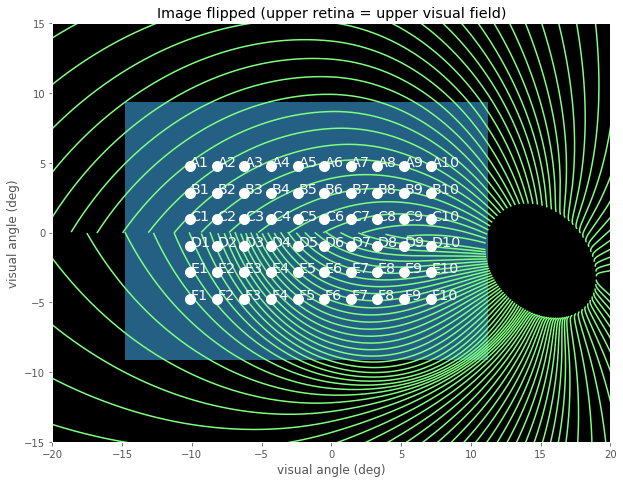

In [6]:
sim.plot_fundus()

In [11]:
stim = p2p.stimuli.image2pulsetrain('letters/A.jpg', argus,
                                    coding='amplitude', max_contrast=True,
                                    rftype='gaussian', rfsize=argus[0].radius / 4.0,
                                    invert=True, dur=0.1)

2017-03-20 17:21:57,274 [pulse2percept.stimuli] [INFO] Loaded file 'letters/A.jpg'.
2017-03-20 17:21:57,697 [pulse2percept.stimuli] [INFO] Image resized to 2825x4925 pixels.


In [12]:
percept = sim.pulse2percept(stim, t_percept=t_percept, tol=0.25)

2017-03-20 17:22:23,601 [pulse2percept.api] [INFO] Starting pulse2percept...
2017-03-20 17:22:24,053 [pulse2percept.api] [INFO] tol=25.0%, 533/609 px selected
2017-03-20 17:25:19,516 [pulse2percept.api] [INFO] Done.


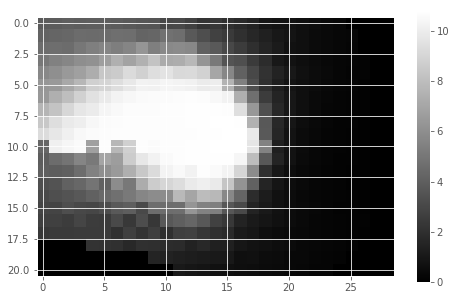

In [13]:
frame = p2p.get_brightest_frame(percept)
plt.figure(figsize=(8, 5))
plt.imshow(frame.data, cmap='gray', vmin=0)
plt.colorbar()